<a href="https://colab.research.google.com/github/vigu2021/NeuroSynth/blob/main/PGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary libraries
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from google.colab import files
import os
from google.cloud import storage
import json
from concurrent.futures import ThreadPoolExecutor
import subprocess
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchaudio.functional import melscale_fbanks
from google.colab import drive

In [ ]:
import os
import tarfile
import gdown

def download_and_extract_from_drive(file_id, split):
    local_tar_path = f"/tmp/{split}.tar.gz"
    extract_path = f"/tmp/{split}/unzipped"
    os.makedirs(extract_path, exist_ok=True)

    # 1. Download the file
    url = f"https://drive.google.com/uc?id={file_id}"
    print(f"⬇️ Downloading {split} from Google Drive...")
    gdown.download(url, local_tar_path)

    # 2. Extract it
    print(f"📦 Extracting {split}...")
    with tarfile.open(local_tar_path, "r:gz") as tar:
        tar.extractall(path=extract_path)

    print(f"✅ Extracted to {extract_path}")
    return extract_path


#train_id = "1iEP1rSGHTcbM0bw_wQ442T5zbpgbwV6W"
val_id = "1RYW37REsk_kIVfEviRSfiMfCJf2ZWvHB"
test_id = "1ilHY7m_pB9b2XUKTf4UpwdcmRnez-YO0"

#train_path = download_and_extract_from_drive(train_id, "train")
val_path = download_and_extract_from_drive(val_id, "val")
test_path = download_and_extract_from_drive(test_id, "test")



⬇️ Downloading val from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1RYW37REsk_kIVfEviRSfiMfCJf2ZWvHB
From (redirected): https://drive.google.com/uc?id=1RYW37REsk_kIVfEviRSfiMfCJf2ZWvHB&confirm=t&uuid=e2d5b200-b30b-40a9-8458-c9f6e495b953
To: /tmp/val.tar.gz
100%|██████████| 1.07G/1.07G [00:10<00:00, 98.8MB/s]


📦 Extracting val...
✅ Extracted to /tmp/val/unzipped
⬇️ Downloading test from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1ilHY7m_pB9b2XUKTf4UpwdcmRnez-YO0
From (redirected): https://drive.google.com/uc?id=1ilHY7m_pB9b2XUKTf4UpwdcmRnez-YO0&confirm=t&uuid=7240128a-86ef-428e-b3c7-224d240b4aec
To: /tmp/test.tar.gz
100%|██████████| 350M/350M [00:04<00:00, 80.6MB/s]


📦 Extracting test...
✅ Extracted to /tmp/test/unzipped


In [ ]:
class NSynthDataset(Dataset):
    def __init__(self, split="train", local_cache_dir="/tmp/"):
        super().__init__()
        self.root_dir = Path(local_cache_dir) / split

        # ── 1. Load labels ───────────────────────────────
        json_files = list(self.root_dir.rglob("examples.json"))
        if not json_files:
            raise FileNotFoundError(f"No examples.json under {self.root_dir}")
        with open(json_files[0]) as f:
            self.labels = json.load(f)

        # ── 2. Map wav files ─────────────────────────────
        wav_paths = {p.stem: p for p in self.root_dir.rglob("*.wav")}
        self.wav_map = wav_paths

        # ── 3. Constants ─────────────────────────────────
        self.pitch_min   = 24
        self.pitch_max   = 84
        self.num_pitches = self.pitch_max - self.pitch_min + 1  # 61

        self.vel_values     = [25, 50, 75, 100, 127]
        self.num_velocities = len(self.vel_values)              # 5

        self.num_sources  = 3
        self.num_families = 11

        # ── 4. Filter for valid + guitar-only ────────────
        kept, skipped = [], 0
        for key, meta in self.labels.items():
            if key not in wav_paths:
                skipped += 1
                continue
            p = meta["pitch"]
            fam = meta["instrument_family"]
            if self.pitch_min <= p <= self.pitch_max and fam == 3:
                kept.append(key)
            else:
                skipped += 1

        self.file_names = kept
        if skipped:
            print(f"⚠️ Skipped {skipped} samples (missing .wav, pitch out of range, or not guitar)")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        fn       = self.file_names[idx]
        wav_path = self.wav_map[fn]
        audio, sr = torchaudio.load(str(wav_path))

        meta = self.labels[fn]

        # ── pitch one‐hot ────────────────────────────────
        pitch      = meta["pitch"]
        pitch_idx  = pitch - self.pitch_min
        pitch_vec  = torch.zeros(self.num_pitches)
        pitch_vec[pitch_idx] = 1.0

        # ── instrument_source one‐hot ────────────────────
        src = meta["instrument_source"]
        src_vec = torch.zeros(self.num_sources)
        src_vec[src] = 1.0

        return {
            "audio": audio,
            "pitch": pitch_vec,
            "instrument_source": src_vec,
        }


# Create spectograms

⚠️ Skipped 11167 samples (missing .wav, pitch out of range, or not guitar)
Loaded 4 examples × 64000 samples
Forward shape : torch.Size([4, 128, 251])
Recon shape   : torch.Size([4, 62976])


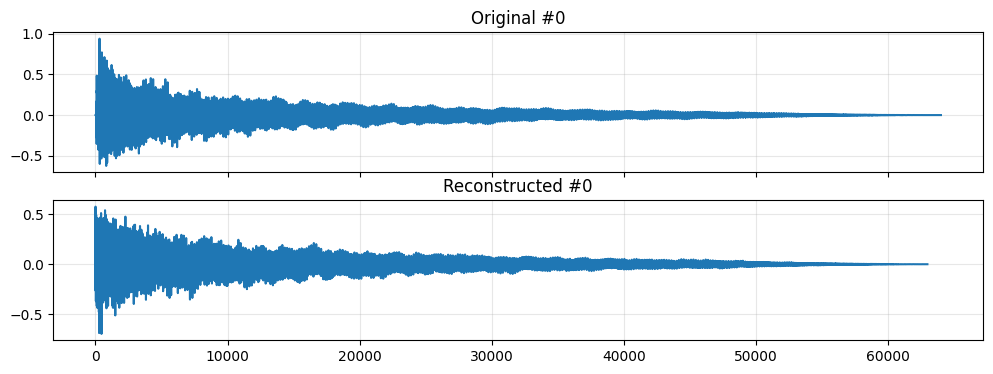

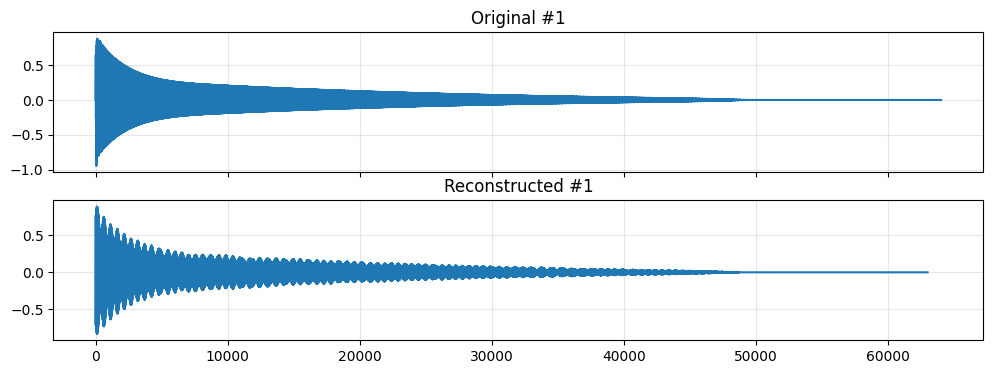

🎵 Saved 'original.wav' and 'reconstructed.wav'. Open with any audio player.


In [ ]:

# ───────────────────────────────────────────────────────────────
# 1.  Phase helpers
# ───────────────────────────────────────────────────────────────


# Calculate differece between phases
def diff(phases, axis=-1):
    return torch.diff(phases, dim=axis)

def unwrap(ph, axis=-1):
    diffs = torch.diff(ph, dim=axis)
    mods  = (diffs + torch.pi) % (2*torch.pi) - torch.pi
    mods[(mods == -torch.pi) & (diffs > 0)] = torch.pi
    corr  = mods - diffs
    csum  = torch.cumsum(corr, dim=axis)
    pad   = torch.zeros_like(ph.narrow(axis, 0, 1))
    return ph + torch.cat([pad, csum], dim=axis)

def inst_freq(ph, axis=-1):
    uf    = unwrap(ph, axis)
    diffs = torch.diff(uf, dim=axis)
    pad   = torch.zeros_like(ph.narrow(axis, 0, 1))
    return torch.cat([pad, diffs], dim=axis) / torch.pi

def norm(x, mean, std):
    return (x - mean) / std


def wav_to_spec(
    wav, sr=16_000, n_fft=1024, hop=256, n_mels=512
):
    if wav.ndim == 3: wav = wav.squeeze(1)       # [B,1,L] → [B,L]
    B, L = wav.shape

    frames     = (L + hop - 1)//hop + 1
    padded_L   = (frames-1)*hop + n_fft
    pad_left   = padded_L - L
    x          = F.pad(wav, (pad_left, 0))

    window = torch.hann_window(n_fft, device=x.device, dtype=x.dtype)
    stft   = torch.stft(x, n_fft, hop, n_fft, window,
                        center=False, return_complex=True)

    mag, ph = stft.abs(), torch.angle(stft)

    mel_fb = T.MelScale(
        n_mels=n_mels,
        sample_rate=sr,
        n_stft=n_fft//2 + 1,
        f_min=0.0,
        f_max=sr/2,
        norm=None,
    ).to(x.device)

    logmel = norm(torch.log(mel_fb(mag)+1e-10), -3.76, 10.05)
    mel_if = norm(inst_freq(mel_fb(ph), 2), 0., 1.)
    return logmel,pad_left

def spec_to_wav(
    logmel: torch.Tensor,
    sr: int = 16_000,
    n_fft: int = 1024,
    hop: int = 256,
    n_mels: int = 512,
    n_iter: int = 500,
):
    device = logmel.device

    # 1. Denormalize & undo log
    log_mel_db = logmel * 10.05 + (-3.76)
    mel_mag     = torch.exp(log_mel_db)
    # 2. Invert Mel → linear-freq magnitude
    inv_mel = T.InverseMelScale(
        n_mels=n_mels,
        sample_rate=sr,
        n_stft=n_fft//2 + 1,
        f_min=0.0,
        f_max=sr/2,
        norm=None,
    ).to(device)
    lin_mag = inv_mel(mel_mag)

    # 3. Griffin–Lim
    griffin = T.GriffinLim(
        n_fft=n_fft,
        win_length=n_fft,
        hop_length=hop,
        window_fn=torch.hann_window,
        power=1.0,
        n_iter=n_iter,
        momentum=0.99,
    ).to(device)

    waveform = griffin(lin_mag)  # runs the specified number of iterations
    return waveform

ds     = NSynthDataset(split="val")
loader = DataLoader(ds, batch_size=4)
batch  = next(iter(loader))

wav    = batch["audio"].to(torch.float32) # [B,1,L]
B, _, L = wav.shape
print(f"Loaded {B} examples × {L} samples")

# ───────────────────────────────────────────────────────────────
# 5.  Forward ↦ Inverse (fixed for no inst‐freq)
# ───────────────────────────────────────────────────────────────
sr, n_fft, hop, n_mels, n_iter = 16_000, 1024, 256, 128, 60

# unpack log-mel & pad
logmel, pad_left = wav_to_spec(
    wav, sr=sr, n_fft=n_fft, hop=hop, n_mels=n_mels
)

# reconstruct waveform (Griffin–Lim)
recon = spec_to_wav(
    logmel,
    sr=sr,
    n_fft=n_fft,
    hop=hop,
    n_mels=n_mels,
    n_iter=n_iter,
)
# crop left padding
recon = recon[:, pad_left:]

print("Forward shape :", logmel.shape)
print("Recon shape   :", recon.shape)



# ───────────────────────────────────────────────────────────────
# 6.  Plot first two
# ───────────────────────────────────────────────────────────────
for i in range(min(2, B)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
    ax1.plot(wav[i, 0].cpu());   ax1.set_title(f"Original #{i}")
    ax2.plot(recon[i].cpu());    ax2.set_title(f"Reconstructed #{i}")
    for ax in (ax1, ax2): ax.grid(alpha=.3)
    plt.show()








original = wav[0].cpu()
reconstructed = recon[0].cpu()

if original.dim() == 1:
    original = original.unsqueeze(0)
if reconstructed.dim() == 1:
    reconstructed = reconstructed.unsqueeze(0)

torchaudio.save("original.wav", original, sample_rate=sr)
torchaudio.save("reconstructed.wav", reconstructed, sample_rate=sr)

print("🎵 Saved 'original.wav' and 'reconstructed.wav'. Open with any audio player.")

In [ ]:
def pixel_norm(x, eps=1e-8):
  return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + eps)

def upsample(x, factor = 2):
  return F.interpolate(x, scale_factor=factor, mode='nearest')

def downsample(x,factor = 2):
  return F.interpolate(x, scale_factor=1/factor, mode='area')

def lerp(a,b,t):
  return a + (b - a) * t

class PixelNorm(nn.Module):
  def __init__(self, eps: float = 1e-8):
      super().__init__()
      self.eps = eps
  def forward(self, x):
      return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.eps)

class Generator(nn.Module):  #PCGAN generator, this generator grows
  def __init__(self,min_resolution, max_resolution, min_channels, max_channels, growing_level):
    super().__init__()
    self.min_resolution = min_resolution
    self.max_resolution = max_resolution
    self.min_channels = min_channels
    self.max_channels = max_channels
    self.growing_level = growing_level

    # Caculate min and max depth (how many time it can grow)
    self.min_depth  = 0
    depths_per_axis = tuple(int(math.log2(mx // mn)) for mn, mx in zip(self.min_resolution, self.max_resolution))
    self.max_depth  = max(depths_per_axis)
    # Initialize growing_depth, will be updated by set_growth
    self.growing_depth = 0.0
    if growing_level > 0:
        self.growing_depth = math.log2(1+(2**(self.max_depth+1)-1)*growing_level)


    # Define layers
    C,H,W = self.min_channels, self.min_resolution[0], self.min_resolution[1]
    self.initial_fc = nn.Linear(320,C*H*W)
    self.pnorm = PixelNorm()
    self.initial_resolution = C,H,W

    self.blocks = nn.ModuleList()
    self.to_spec = nn.ModuleList()
    for depth in range(self.min_depth,self.max_depth+1):
      # Note: This calculation is for generator blocks, where channels decrease as resolution increases
      scale = self.max_depth - depth
      next_scale = max(self.max_depth - depth - 1, 0)

      in_ch = min(self.max_channels, self.min_channels * (2 ** scale))
      out_ch = min(self.max_channels, self.min_channels * (2 ** next_scale))

      # The first block (depth=0) has a different in_ch because it comes from the initial fc layer
      if depth == 0:
          in_ch = self.min_channels
      else:
          # For subsequent blocks, the in_ch is the out_ch of the previous block
          prev_scale = self.max_depth - (depth - 1)
          in_ch = min(self.max_channels, self.min_channels * (2 ** max(self.max_depth - (depth-1) -1,0)))


      block = nn.Sequential(
          nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
          nn.LeakyReLU(0.2, inplace = True),
          PixelNorm(),
          nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
          nn.LeakyReLU(0.2, inplace = True),
          PixelNorm()
      )
      self.blocks.append(block)

      # To spec
      self.to_spec.append(nn.Conv2d(out_ch, 1, 1, 1, 0))


    self.LRelu = nn.LeakyReLU(0.2, inplace = True)
    self.tanh = nn.Tanh()

  def forward(self, z, pitch, instrument_source):
    # 1) Concatenate all the condition vectors
    x = torch.cat([
        z,
        pitch,
        instrument_source
    ], dim=1)  # [B, initial_dim]
    x = self.pnorm(x)
    x = self.initial_fc(x) # [B,C*H*W]
    C,H,W = self.initial_resolution
    x = x.view(-1,C,H,W) # [B,C,H,W]
    x = self.LRelu(x)

    fade_depth = int(self.growing_depth)
    alpha = self.growing_depth - fade_depth

    # Pass through all stable blocks up to fade_depth
    for depth in range(fade_depth + 1):
        if depth > 0:
            x = upsample(x)
        x = self.blocks[depth](x)

    # Now x is the feature map from block[fade_depth]

    # If stable at max resolution or not fading at all, just output the image
    if alpha == 0.0 or fade_depth == self.max_depth:
        img = self.to_spec[fade_depth](x)
        return self.tanh(img)

    # --- Fading Logic ---
    # The new path's image comes from the next block (fade_depth + 1)
    x_new = upsample(x)
    x_new = self.blocks[fade_depth + 1](x_new)
    img_new = self.to_spec[fade_depth + 1](x_new)

    # The old path's image comes from the current block's features (to_spec[fade_depth])
    # and needs to be upsampled to match the new image's resolution.
    img_old = self.to_spec[fade_depth](x)
    img_old = upsample(img_old)

    # Blend the old and new images
    img = lerp(img_old, img_new, alpha)

    return self.tanh(img)


class MinibatchStdDev(nn.Module):
    def __init__(self, eps: float = 1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        # x : [B, C, H, W]
        batch_var = (x - x.mean(0, keepdim=True)).pow(2).mean(0)  # var over batch
        batch_std = torch.sqrt(batch_var + self.eps)              # [C,H,W]
        scalar    = batch_std.mean().view(1, 1, 1, 1)             # [1,1,1,1]
        std_map   = scalar.repeat(x.size(0), 1, x.size(2), x.size(3))
        return torch.cat([x, std_map], dim=1)                     # [B,C+1,H,W]
class Discriminator(nn.Module):
    def __init__(self, min_resolution, max_resolution, min_channels, max_channels, growing_level):
        super().__init__()
        self.min_resolution = min_resolution
        self.max_resolution = max_resolution
        self.min_channels = min_channels
        self.max_channels = max_channels
        self.growing_level = growing_level

        # Calculate min and max depth (how many times it can shrink
        self.min_depth = 0
        depths_per_axis = tuple(int(math.log2(mx // mn)) for mn, mx in zip(self.min_resolution, self.max_resolution))
        self.max_depth = max(depths_per_axis)
        # Initialize growing_depth, will be updated by set_growth
        self.growing_depth = 0.0
        if growing_level > 0:
            self.growing_depth = math.log2(1 + (2**(self.max_depth + 1) - 1) * growing_level)

        self.from_spec = nn.ModuleList()  # 1×1 conv : 2 → feat
        self.blocks = nn.ModuleList()      # conv + downsample

        # Define blocks from HIGHEST resolution to LOWEST
        for depth in range(self.max_depth, self.min_depth - 1, -1):
            scale = self.max_depth - depth
            next_scale = self.max_depth - max(depth - 1, 0)

            in_ch = min(self.max_channels, self.min_channels * (2 ** scale))
            out_ch = min(self.max_channels, self.min_channels * (2 ** next_scale))

            self.from_spec.append(nn.Conv2d(1, in_ch, 1, 1, 0))

            if depth == self.min_depth:  # Lowest resolution block (e.g., 2x16)
                block = nn.Sequential(
                    MinibatchStdDev(),                      # Adds 1 channel -> in_ch + 1
                    nn.Conv2d(in_ch + 1, in_ch, 3, 1, 1),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Conv2d(in_ch, self.max_channels, kernel_size=self.min_resolution, padding=0), # Flatten
                    nn.LeakyReLU(0.2, inplace=True),
                )
            else:
                block = nn.Sequential(
                    nn.Conv2d(in_ch, in_ch, 3, 1, 1),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Conv2d(in_ch, out_ch, 3, 1, 1),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.AvgPool2d(2),  # H,W ÷ 2
                )
            self.blocks.append(block)

        # Final dense layers
        self.final_dense     = nn.Linear(self.max_channels, 1)   # real/fake
        self.final_pitch_cls = nn.Linear(self.max_channels, 61)  # pitch
        self.final_src_cls   = nn.Linear(self.max_channels,  3)  # instrument_source

    def discriminator(self, spec):
        # Determine the resolution depth of the input image directly for robustness
        image_H = spec.shape[2]
        image_depth = int(round(math.log2(image_H / self.min_resolution[0])))

        # Get alpha from the network's current growth state
        fade_depth  = int(self.growing_depth)
        alpha       = self.growing_depth - fade_depth

        # The first block to use corresponds to the image's resolution
        start_block_idx = self.max_depth - image_depth

        # If not fading (alpha is 0 or 1), or at the lowest res, it's a simple pass
        if alpha == 0.0 or image_depth == 0:
            x = self.from_spec[start_block_idx](spec)
            x = self.blocks[start_block_idx](x)
        else: # We are in a fade-in transition
            x_new = self.from_spec[start_block_idx](spec)
            x_new = self.blocks[start_block_idx](x_new) # This block includes downsampling

            # Lower-resolution path (the old stable block)
            spec_old = F.avg_pool2d(spec, 2)
            x_old = self.from_spec[start_block_idx + 1](spec_old)

            # Blend the feature maps of the two paths
            x = lerp(x_old, x_new, alpha)

        # --- Run the remaining (lower-resolution) blocks ---
        for i in range(start_block_idx + 1, len(self.blocks)):
            x = self.blocks[i](x)

        x     = x.view(x.size(0), -1)
        real = self.final_dense(x).squeeze(1)    # [B]
        pitch_logits = self.final_pitch_cls(x)   # [B, 61]
        src_logits   = self.final_src_cls(x)     # [B,  3]

        return real, pitch_logits, src_logits

    def forward(self, spec):
        return self.discriminator(spec)









In [ ]:
min_res = (8,4);  max_res = (512,256)
min_ch  = 8;      max_ch  = 512
B       = 4
device  = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize at g=0
G = Generator(min_res, max_res, min_ch, max_ch, 0.0).to(device)
D = Discriminator(min_res, max_res, min_ch, max_ch, 0.0).to(device)

def set_growth(net, g):
    g = max(0.0, min(1.0, g))
    net.growing_level = g
    if g == 0:
        net.growing_depth = 0.0
    else:
        net.growing_depth = math.log2(1 + (2**(net.max_depth+1) - 1) * g)

def run_once(g):
    print("-" * 60)
    # sync G and D
    for net in (G, D):
        set_growth(net, g)

    # sample noise + all 4 condition one-hots
    z = torch.randn(B, 256, device=device)

    pitch_idxs = torch.randint(0, 61, (B,), device=device)
    pitch      = torch.nn.functional.one_hot(pitch_idxs, 61).float()

    src_idxs = torch.randint(0, 3, (B,), device=device)
    src      = torch.nn.functional.one_hot(src_idxs, 3).float()

    try:
        with torch.no_grad():
            G.eval()
            D.eval()
            fake = G(z, pitch, src)
            real_logits, *_ = D(fake)

        print(f"OK! grow={g:.3f}  depth={G.growing_depth:.2f}")
        print(f"    G_out={tuple(fake.shape)} | D_real={tuple(real_logits.shape)}")

    except Exception as e:
        print(f"FAILED! grow={g:.3f}")
        print("ERROR:", e)
        print(f" depth={G.growing_depth:.2f}")
        import traceback; traceback.print_exc()

# sweep growth from 0.0 to 1.0 in 0.1 steps
for g in np.arange(0.0, 1.01, 0.1):
    run_once(g)


# 🎯 GANSynth Core Loss Functions

## 🧠 Generator Loss

$$
\mathcal{L}_{G} = \mathbb{E}_{z \sim p(z)} \left[ \text{softplus}(-D(G(z))) \right]
$$

## 🛡️ Discriminator Loss

$$
\mathcal{L}_{D} = \mathbb{E}_{x \sim p_{\text{data}}} \left[ \text{softplus}(-D(x)) \right] + \mathbb{E}_{z \sim p(z)} \left[ \text{softplus}(D(G(z))) \right] + \lambda_{\text{real-gp}} \cdot \|\nabla_x D(x)\|_2^2 + \lambda_{\text{fake-gp}} \cdot \|\nabla_{\hat{x}} D(\hat{x})\|_2^2
$$

## 🎵 Pitch Classification Loss

$$
\mathcal{L}_{\text{total}} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i) + \lambda_{\text{wd}} \sum_{w \in \mathcal{W}} \|w\|_2^2
$$



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import trange
import os
from torch.utils.data import DataLoader


train_dataset = NSynthDataset(split="train")
val_dataset   = NSynthDataset(split="val")


train_loader = DataLoader(
    dataset           = train_dataset,      # your SpectrogramDataset(...)
    batch_size        = 8,
    shuffle           = True,               # shuffle for training
    num_workers       = 4,
    pin_memory        = True,               # ⇢ faster GPU transfers
    prefetch_factor   = 2,                  # each worker preloads 2 batches
    persistent_workers=True                 # keeps workers alive across epochs
)


val_loader = DataLoader(
    dataset           = val_dataset,
    batch_size        = 8,
    shuffle           = False,
    num_workers       = 4,
    pin_memory        = True,
    prefetch_factor   = 2,
    persistent_workers=True
)

# --- Google Drive Integration & Checkpoint Setup ---
# This part handles saving and loading checkpoints from Google Drive (if in Colab)
# or a local directory otherwise.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    CHECKPOINT_DIR = '/content/drive/MyDrive/gan_checkpoints12'
    print("Google Drive mounted. Checkpoints will be saved to:", CHECKPOINT_DIR)
except ImportError:
    CHECKPOINT_DIR = './gan_checkpoints'
    print("Not in Google Colab. Checkpoints will be saved locally to:", CHECKPOINT_DIR)

os.makedirs(CHECKPOINT_DIR, exist_ok=True)


# ───────────────────────── hyper-params ─────────────────────────
noise_dim        = 256
epochs           = 100
batch_size       = 32
grow_total_steps = 80000
grow_cap         = 0.9999
lambda_gp        = 1
log_every        = 100
val_every        = 1_000
checkpoint_every = 1_000 # Save a checkpoint every 1000 global steps
use_amp          = torch.cuda.is_available()
NUM_PITCHES      = 61      # MIDI 24-84
# ────────────────────────────────────────────────────────────────

# Assume G, D, train_loader, val_loader, and wav_to_spec are defined elsewhere
# Example (make sure these are defined in your script):
# G = YourGeneratorModel()
# D = YourDiscriminatorModel()
# train_loader, val_loader = your_data_loaders()
# def wav_to_spec(wav): ...
# def set_growth(model, g): ...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G, D = G.to(device), D.to(device)
G.train(); D.train()

g_opt = optim.Adam(G.parameters(), lr=8e-4, betas=(0.5, 0.999))
d_opt = optim.Adam(D.parameters(), lr=5e-5, betas=(0.5, 0.999))
ce_loss = nn.CrossEntropyLoss()

# ── losses ─────────────────────────────────────────────────────
# ── hyper‐parameter weights for each attribute loss ────────
λ_pitch = 5
λ_src   = 5

# ── Discriminator loss (adversarial + real‐only classification + GP) ───
def d_loss_fn(
    real_logits, fake_logits,
    real_pitch_logits, real_src_logits,
    pitch_idx, src_idx,
    real_spec, fake_spec
):
    # adversarial
    adv = F.softplus(-real_logits).mean() + F.softplus(fake_logits).mean()
    # classification on real specs only
    Lp = ce_loss(real_pitch_logits, pitch_idx)
    Ls = ce_loss(real_src_logits,   src_idx)
    # gradient penalty
    gp = gradient_penalty(real_spec, real_logits) + gradient_penalty(fake_spec, fake_logits)

    return (
        adv
      + λ_pitch * Lp
      + λ_src   * Ls
      + lambda_gp * gp
    )

# ── Generator loss (adversarial + fake‐classification) ────────────────
def g_loss_fn(
    fake_logits,
    fake_pitch_logits,fake_src_logits,
    pitch_idx,  src_idx
):
    adv = F.softplus(-fake_logits).mean()
    # encourage D to classify fake with the correct labels
    Lp = ce_loss(fake_pitch_logits, pitch_idx)
    Ls = ce_loss(fake_src_logits,   src_idx)

    return (
        adv
      + λ_pitch * Lp
      + λ_src   * Ls
    )


def gradient_penalty(inputs, logits):
    grads = torch.autograd.grad(
        logits, inputs, torch.ones_like(logits),
        create_graph=True, retain_graph=True
    )[0]
    return grads.pow(2).view(grads.size(0), -1).sum(1).mean()
# ───────────────────────────────────────────────────────────────

# ── Checkpointing Functions ────────────────────────────────────
def save_checkpoint(global_step, g_growth):
    """Saves models, optimizers, and training state to a checkpoint file."""
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_{global_step:09d}.pt')
    print(f"\n💾 Saving checkpoint to {checkpoint_path}...")
    state = {
        'global_step': global_step,
        'g_growth': g_growth,
        'G_state_dict': G.state_dict(),
        'D_state_dict': D.state_dict(),
        'g_opt_state_dict': g_opt.state_dict(),
        'd_opt_state_dict': d_opt.state_dict(),
    }
    torch.save(state, checkpoint_path)

def load_latest_checkpoint():
    """Loads the most recent checkpoint to resume training."""
    checkpoints = sorted([f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pt')])
    if not checkpoints:
        print("No checkpoint found. Starting training from scratch.")
        return 0 # Initial global_step

    latest_checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoints[-1])
    print(f"🔄 Loading latest checkpoint from {latest_checkpoint_path}...")
    checkpoint = torch.load(latest_checkpoint_path, map_location=device)

    G.load_state_dict(checkpoint['G_state_dict'])
    D.load_state_dict(checkpoint['D_state_dict'])
    g_opt.load_state_dict(checkpoint['g_opt_state_dict'])
    d_opt.load_state_dict(checkpoint['d_opt_state_dict'])

    print(f"Resuming training from global step {checkpoint['global_step']}.")
    return checkpoint['global_step']





# ── Validation‐only Discriminator Loss (no GP) ────────────────────
def d_val_loss_fn(
    real_logits, fake_logits,
    real_pitch_logits, real_src_logits,
    pitch_idx, src_idx
):
    # adversarial term only
    adv = F.softplus(-real_logits).mean() + F.softplus(fake_logits).mean()
    # classification on real specs only
    Lp = ce_loss(real_pitch_logits, pitch_idx)
    Ls = ce_loss(real_src_logits,   src_idx)
    return adv + λ_pitch*Lp + + λ_src*Ls


def save_spectrogram_grid(real_spec, fake_spec, step, max_rows=4):
    """
    Save a (max_rows × 2) grid     [ Real | Fake ]
    real_spec, fake_spec : [B, 1, H, W] log‑mel tensors.
    """
    real = real_spec.detach().cpu().numpy()
    fake = fake_spec.detach().cpu().numpy()
    rows = min(max_rows, real.shape[0])

    fig, axs = plt.subplots(rows, 2, figsize=(6, 3 * rows))
    if rows == 1:                       # force 2‑D index when rows==1
        axs = axs[None, :]

    for r in range(rows):
        for c, arr in enumerate([real, fake]):
            ax = axs[r, c]
            ax.imshow(arr[r, 0], origin="lower", aspect="auto", cmap="magma")
            ax.axis("off")
            ax.set_title("Real" if c == 0 else "Fake")



# ─── 3. DROP‑IN REPLACEMENT FOR YOUR evaluate() ─────────────────
@torch.no_grad()
def evaluate(loader, step=None, vis_rows=4):
    """
    Returns:
        val_g_loss, val_d_loss,
        real_pitch_acc, real_src_acc,
        fake_pitch_acc, fake_src_acc
    Also saves a side‑by‑side spectrogram image for the *first* batch
    if `step` is provided.
    """
    G.eval(); D.eval()
    g_sum = d_sum = 0.0
    n_real = n_fake = 0
    real_pitch_ok = real_src_ok = 0
    fake_pitch_ok = fake_src_ok = 0
    first_batch_done = False

    for batch in loader:
        wav      = batch["audio"].to(device).float()
        pitch_1h = batch["pitch"].to(device)
        src_1h   = batch["instrument_source"].to(device)
        idx_p, idx_s = pitch_1h.argmax(1), src_1h.argmax(1)

        # build real spec at current G resolution
        logmel, _ = wav_to_spec(wav)
        H, W = G(torch.randn(1, noise_dim, device=device),
                 pitch_1h[:1], src_1h[:1]).shape[-2:]
        real_spec = F.adaptive_avg_pool2d(logmel.unsqueeze(1), (H, W))

        B  = real_spec.size(0)
        z  = torch.randn(B, noise_dim, device=device)

        real_logits, rp, rs = D(real_spec)
        fake_spec           = G(z, pitch_1h, src_1h)
        fake_logits, fp, fs = D(fake_spec)

        # --- losses ---
        d_sum += d_val_loss_fn(real_logits, fake_logits, rp, rs,
                               idx_p, idx_s).item() * B
        g_sum += g_loss_fn(fake_logits, fp, fs,
                           idx_p, idx_s).item() * B

        # --- accuracies ---
        real_pitch_ok += (rp.argmax(1) == idx_p).sum().item()
        real_src_ok   += (rs.argmax(1) == idx_s).sum().item()
        fake_pitch_ok += (fp.argmax(1) == idx_p).sum().item()
        fake_src_ok   += (fs.argmax(1) == idx_s).sum().item()
        n_real += B
        n_fake += B

        # --- visualise once per evaluate() call ---
        if (not first_batch_done) and (step is not None):
            save_spectrogram_grid(real_spec, fake_spec, step,
                                  max_rows=vis_rows)
            first_batch_done = True

    G.train(); D.train()
    return (g_sum / n_real, d_sum / n_real,
            real_pitch_ok / n_real, real_src_ok / n_real,
            fake_pitch_ok / n_fake, fake_src_ok / n_fake)






global_step = load_latest_checkpoint()
for epoch in trange(epochs, desc="Epoch"):
    train_D_this_epoch = (epoch % 2 == 1)
    for batch_idx, batch in enumerate(train_loader):
        # ── Resume from checkpoint ────────────────────────────
        if global_step > epoch * len(train_loader) + batch_idx:
            continue

        # ── Progressive‐growing update ─────────────────────────
        g_raw = global_step / grow_total_steps
        g     = min(grow_cap, g_raw)
        set_growth(G, g)
        set_growth(D, g)
        # ── Load & move to device ─────────────────────────────────
        wav    = batch["audio"].to(device).float()
        p1h    = batch["pitch"].to(device)
        s1h    = batch["instrument_source"].to(device)

        idx_p  = p1h.argmax(1)
        idx_s  = s1h.argmax(1)

        # ── Spectrogram & resizing ─────────────────────────────────
        logmel, _ = wav_to_spec(wav)
        # compute the current target H,W from G’s output shape
        with torch.no_grad():
          H, W = G(
              torch.randn(1, noise_dim, device=device),
              p1h[:1], s1h[:1]
          ).shape[-2:]
          real_spec = logmel.unsqueeze(1)               # [B,1,n_mels,T]
          real_spec = F.interpolate(real_spec, size=(H, W), mode='bilinear', align_corners=False)


        B = real_spec.size(0)
        z = torch.randn(B, noise_dim, device=device)

                  # ── Discriminator step ─────────────────────────────────
        if train_D_this_epoch:                       # odd epochs
          d_opt.zero_grad()
          G.eval();  D.train()

          with torch.no_grad():
              fake_spec = G(z, p1h, s1h)

          real_spec.requires_grad_()
          fake_spec.requires_grad_()

          rl, rp, rs = D(real_spec)
          fl, fp, fs = D(fake_spec)

          d_loss = d_loss_fn(rl, fl, rp, rs, idx_p, idx_s,
                            real_spec, fake_spec)
          d_loss.backward()
          d_opt.step()

        else:                                # even epochs –‑ D frozen
          G.eval();  D.eval()
          with torch.no_grad():            # forward pass without graph
              fake_spec = G(z, p1h, s1h)
              rl, rp, rs = D(real_spec)
              fl, fp, fs = D(fake_spec)

          d_loss = d_val_loss_fn(rl, fl, rp, rs, idx_p, idx_s)


        # ── Generator step  (runs EVERY batch) ─────────────────
        g_opt.zero_grad()
        G.train(); D.eval()

        fake_spec = G(torch.randn(B, noise_dim, device=device), p1h, s1h)
        fl, fp, fs = D(fake_spec)

        g_loss = g_loss_fn(fl, fp, fs, idx_p, idx_s)
        g_loss.backward()
        g_opt.step()


        # ── bump global step & logging / checkpointing … ───────
        global_step += 1
        if global_step % log_every == 0:
            print(f"[{global_step:7d}] D={d_loss.item():6.3f} | "
                  f"G={g_loss.item():6.3f} | grow={g:.4f}")


        # ── Logging & checkpointing ───────────────────────────────
        if global_step % checkpoint_every == 0:
            (val_g, val_d,
            r_acc_p, r_acc_s,
            f_acc_p, f_acc_s) = evaluate(val_loader)

            print(
                f"🔍 VAL {global_step}: G={val_g:.3f} D={val_d:.3f} | "
                f"Real Acc(p/s)={r_acc_p:.2%}/{r_acc_s:.2%} | "
                f"Fake Acc(p/s)={f_acc_p:.2%}/{f_acc_s:.2%}"
            )

            save_checkpoint(global_step, g)


    print("✅ Training complete!")

⚠️ Skipped 265004 samples (missing .wav, pitch out of range, or not guitar)
⚠️ Skipped 11167 samples (missing .wav, pitch out of range, or not guitar)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted. Checkpoints will be saved to: /content/drive/MyDrive/gan_checkpoints12
No checkpoint found. Starting training from scratch.


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

[    100] D=451.261 | G=13.327 | grow=0.0020
[    200] D=598.029 | G=35.648 | grow=0.0040
[    300] D=1003.158 | G=96.611 | grow=0.0060
[    400] D=891.160 | G= 4.214 | grow=0.0080
[    500] D=1023.112 | G=69.566 | grow=0.0100
[    600] D=565.473 | G= 1.834 | grow=0.0120
[    700] D=490.028 | G= 4.412 | grow=0.0140
[    800] D=707.149 | G= 0.000 | grow=0.0160
[    900] D=644.036 | G= 0.296 | grow=0.0180
[   1000] D=759.450 | G= 0.521 | grow=0.0200
🔍 VAL 1000: G=3.162 D=287.761 | Real Acc(p/s)=28.72%/34.08% | Fake Acc(p/s)=97.42%/98.61%

💾 Saving checkpoint to /content/drive/MyDrive/gan_checkpoints12/checkpoint_000001000.pt...
[   1100] D=609.276 | G= 0.109 | grow=0.0220
[   1200] D=307.940 | G= 0.116 | grow=0.0240
[   1300] D=491.027 | G= 1.649 | grow=0.0260
[   1400] D=346.908 | G= 1.095 | grow=0.0280
[   1500] D=371.632 | G= 0.005 | grow=0.0300
[   1600] D=312.347 | G= 0.080 | grow=0.0320
[   1700] D=455.696 | G= 4.811 | grow=0.0340
[   1800] D=263.549 | G= 0.004 | grow=0.0360
[   19

Epoch:   1%|          | 1/100 [01:36<2:39:59, 96.97s/it]

✅ Training complete!
[   3100] D=11.288 | G= 4.802 | grow=0.0620
[   3200] D= 4.407 | G= 2.808 | grow=0.0640
[   3300] D= 1.638 | G= 3.947 | grow=0.0660
[   3400] D= 3.253 | G= 2.550 | grow=0.0680
[   3500] D= 2.902 | G= 4.199 | grow=0.0700
[   3600] D= 2.593 | G= 4.286 | grow=0.0720
[   3700] D= 2.895 | G= 3.627 | grow=0.0740
[   3800] D= 0.704 | G= 3.444 | grow=0.0760
[   3900] D= 2.550 | G= 4.566 | grow=0.0780
[   4000] D= 2.565 | G= 3.214 | grow=0.0800
🔍 VAL 4000: G=3.321 D=13.216 | Real Acc(p/s)=69.16%/52.68% | Fake Acc(p/s)=99.01%/99.93%

💾 Saving checkpoint to /content/drive/MyDrive/gan_checkpoints12/checkpoint_000004000.pt...
[   4100] D= 0.483 | G= 3.369 | grow=0.0820
[   4200] D= 2.387 | G= 3.454 | grow=0.0840
[   4300] D= 3.717 | G= 3.672 | grow=0.0860
[   4400] D= 2.902 | G= 3.322 | grow=0.0880
[   4500] D= 3.497 | G= 3.527 | grow=0.0900
[   4600] D= 1.890 | G= 3.182 | grow=0.0920
[   4700] D= 0.532 | G= 3.852 | grow=0.0940
[   4800] D= 2.649 | G= 3.194 | grow=0.0960
[   49

Epoch:   2%|▏         | 2/100 [05:03<4:23:40, 161.43s/it]

✅ Training complete!
[   6100] D= 0.789 | G= 2.777 | grow=0.1220
[   6200] D= 0.456 | G= 1.722 | grow=0.1240
[   6300] D= 5.147 | G= 1.706 | grow=0.1260
[   6400] D= 0.609 | G= 1.480 | grow=0.1280
[   6500] D= 1.745 | G= 1.254 | grow=0.1300
[   6600] D= 1.928 | G= 1.044 | grow=0.1320


Epoch:   2%|▏         | 2/100 [05:25<4:25:30, 162.55s/it]


KeyboardInterrupt: 

In [ ]:
import os, torch, matplotlib.pyplot as plt, torchaudio

# ─── config ───────────────────────────────────────────────────────────────
MIN_RES, MAX_RES = (8, 4), (512, 256)
MIN_CH, MAX_CH   = 8, 512
BATCH_SIZE       = 1
Z_DIM            = 256
SAMPLE_RATE      = 16_000
N_MELS           = 512        # target mel bins
N_FFT            = 1024
HOP_LENGTH       = 256
GRIFFIN_ITERS    = 1000
GROW_LEVEL       = 0.9999
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ───────────────────────────────────────────────────────────────────────────

def test_generator_from_checkpoint(
    model_path: str,
    pitch_vec: torch.Tensor,
    source_vec: torch.Tensor,
    output_dir: str = "./generated_output",
):
    """Generate log‑mel from a checkpoint, plot it, and invert to waveform."""
    os.makedirs(output_dir, exist_ok=True)
    print(f"🔍 Loading generator from {model_path}")
    ckpt = torch.load(model_path, map_location=DEVICE)

    G = Generator(
        min_resolution=MIN_RES,
        max_resolution=MAX_RES,
        min_channels=MIN_CH,
        max_channels=MAX_CH,
        growing_level=GROW_LEVEL,
    ).to(DEVICE)

    G.load_state_dict(ckpt["G_state_dict"])
    set_growth(G, GROW_LEVEL)
    G.eval()

    # prepare conditioning vector
    z          = torch.randn(BATCH_SIZE, Z_DIM, device=DEVICE)
    pitch_vec  = pitch_vec.unsqueeze(0).to(DEVICE).float()   # [1, 61]
    source_vec = source_vec.unsqueeze(0).to(DEVICE).float()  # [1, 3]

    with torch.no_grad():
        raw = G(z, pitch_vec, source_vec)[0, 0].cpu()  # drop batch+channel

    # automatic orientation fix
    if raw.shape[0] == N_MELS:
        spec_logmel = raw                 # [512, 256]  correct
    elif raw.shape[1] == N_MELS:
        spec_logmel = raw.permute(1, 0)   # swap to [512, 256]
    else:
        raise ValueError(
            f"Neither dimension equals N_MELS={N_MELS}; got {raw.shape}"
        )

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.imshow(spec_logmel, origin="lower", aspect="auto")
    ax.set_title("Generated Log‑Mel Spectrogram")
    ax.set_xlabel("Time frame"); ax.set_ylabel("Mel bin")
    fig.colorbar(ax.images[0], ax=ax, orientation="horizontal")
    fig.savefig(os.path.join(output_dir, "generated_spec.png"))
    plt.close(fig)
    spec_tensor = spec_logmel.unsqueeze(0).to(DEVICE)        # [1, 512, 256]

    wav = spec_to_wav(
        spec_tensor,
        sr=SAMPLE_RATE,
        n_fft=N_FFT,
        hop=HOP_LENGTH,
        n_mels=N_MELS,
        n_iter=GRIFFIN_ITERS,
    ).squeeze(0).cpu()                                       # [T]

    fig, ax = plt.subplots(figsize=(10, 2))
    ax.plot(wav.numpy())
    ax.set_title("Reconstructed Waveform")
    ax.set_xlim(0, wav.numel()); ax.set_ylim(-1.0, 1.0)
    fig.savefig(os.path.join(output_dir, "generated_waveform.png"))
    plt.close(fig)

    torchaudio.save(
        os.path.join(output_dir, "generated_audio.wav"),
        wav.unsqueeze(0),  # mono
        SAMPLE_RATE,
    )

    print("✅ Saved spectrogram, waveform image, and audio file to", output_dir)


if __name__ == "__main__":
    pitch  = torch.zeros(61); pitch[40] = 1
    source = torch.zeros(3);  source[2] = 1

    test_generator_from_checkpoint(
        model_path="/checkpoint_000083000.pt",
        pitch_vec=pitch,
        source_vec=source,
        output_dir="./gen_test_output",
    )


🔍 Loading generator from /checkpoint_000083000.pt


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory